In [11]:
import pandas as pd
import math
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import dill as dill
import json

from Utilities.Preprocessors import DataPreprocessor
from Utilities.Transformers import MultilabelTransformer
from Utilities.Transformers import LocationTransformer
from Utilities.Transformers import ParkingTransformer
from sklearn.preprocessing import FunctionTransformer
from Utilities.Common import check_models, check_overfitting, get_fold, get_metrics

from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils import shuffle
from sklearn.inspection import permutation_importance

import warnings
warnings.filterwarnings('ignore')

In [18]:
N_FOLDS = 5
LOCATIONS_POSTALCODES_PATH = "Utilities/PostalcodesSearch/locations_postalcodes.json"
SCORING = {'R2': 'r2',
           'explained_variance': 'explained_variance',
           'MSE': 'neg_mean_squared_error',
           'MAE': 'neg_mean_absolute_error'}

In [6]:
from sklearn.metrics import mean_absolute_error

test_1 = [1,1,1]
test_2 = [1.1,0.9,1.1]

test_1 = [i * 1000 for i in test_1]
test_2 = [i * 1000 for i in test_2]

mean_absolute_error(test_1, test_2)

100.0

In [19]:
# Determines the cross-validation splitting strategy
CV_FOLDS = 5
LOCATION_MIN_OCCURANCES = 10
outlier_cols = ['Цена', 'Общая площадь']
locations_postalcodes_path = "streetsIndexes.json"

In [20]:
df2 = pd.read_csv("Data/kursk_apartments.csv", index_col=0)
df2.head()

,Район,Цена,Количество комнат,Общая площадь,Площадь кухни,Этаж,Балкон или лоджия,Тип комнат,Санузел,Ремонт,...,Можно с детьми,Можно с животными,Можно курить,Тип дома,Этажей в доме,Пассажирский лифт,Грузовой лифт,Парковка,Лифт,Улица
0,р-н Центральный,35000.0,3,116.0,20.0,5,"балкон, лоджия",изолированные,раздельный,евро,...,1,0,0,кирпичный,9,1,0,за шлагбаумом во дворе,1,ул. Карла Либкнехта
1,р-н Центральный,27000.0,3,80.0,15.0,2,балкон,изолированные,совмещенный,евро,...,1,0,0,кирпичный,5,0,0,за шлагбаумом во дворе,0,Красная пл.
2,р-н Центральный,12000.0,2,58.0,12.0,1,балкон,изолированные,раздельный,косметический,...,1,0,0,панельный,17,1,1,открытая во дворе,1,пр-т Вячеслава Клыкова
3,р-н Центральный,13000.0,2,75.0,15.0,5,лоджия,изолированные,NaN,косметический,...,1,0,0,монолитный,10,1,0,открытая во дворе,1,пр-т Победы
4,р-н Центральный,15000.0,3,85.0,13.0,9,лоджия,"изолированные, смежные",раздельный,евро,...,1,0,0,панельный,10,0,0,открытая во дворе,0,Студенческая ул.


In [21]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 215 entries, 0 to 216
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Район              215 non-null    object 
 1   Цена               215 non-null    float64
 2   Количество комнат  215 non-null    int64  
 3   Общая площадь      215 non-null    float64
 4   Площадь кухни      215 non-null    float64
 5   Этаж               215 non-null    int64  
 6   Балкон или лоджия  168 non-null    object 
 7   Тип комнат         107 non-null    object 
 8   Санузел            185 non-null    object 
 9   Ремонт             215 non-null    object 
 10  Мебель             179 non-null    object 
 11  Техника            192 non-null    object 
 12  Интернет и ТВ      105 non-null    object 
 13  Можно с детьми     215 non-null    int64  
 14  Можно с животными  215 non-null    int64  
 15  Можно курить       215 non-null    int64  
 16  Тип дома           215 non

In [22]:
class MultilabelTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, naming_prefix='', dropna=False):
        self.naming_prefix = naming_prefix
        self.dropna = dropna

    def fit(self, X, y=None):
        self.vectorizer = CountVectorizer(analyzer=lambda x: set(x))
        self.vectorizer.fit(
            X.apply(lambda x: str(x).replace(', ', ',').split(',')))
        if self.dropna:
            self.feature_names = list(
                filter(lambda x: x != 'nan', self.vectorizer.get_feature_names_out()))
        else:
            self.feature_names = self.vectorizer.get_feature_names_out()
        return self

    def transform(self, X, y=None):
        encoded_column = self.vectorizer.transform(
            X.apply(lambda x: str(x).replace(', ', ',').split(','))).A
        # ToDo rewrite to clean code following part of method.
        column_names = list(map(
            lambda x: f'{self.naming_prefix}_{str(x)}', self.vectorizer.get_feature_names_out()))
        onehot_df = pd.DataFrame(
            encoded_column, columns=column_names, index=X.index)
        if self.dropna:
            try:
                onehot_df.drop(f'{self.naming_prefix}_nan',
                               axis=1, inplace=True)
            except KeyError:
                pass
        return onehot_df

    def get_feature_names_out(self, input_features=None):
        return self.feature_names

In [23]:
outlier_cols = ['Цена', 'Общая площадь']
df2 = df2[(np.abs(stats.zscore(df2[outlier_cols])) < 2).all(axis=1)]
df2.dropna(subset=outlier_cols, how='all', inplace=True)
df2.shape

(203, 23)

In [33]:
drop_columns = ['Район', 'Парковка', 'Тип комнат', 'Санузел',
                'Ремонт', 'Мебель', 'Техника', 'Интернет и ТВ', 'Тип дома']
passthrough_columns = ['Цена', 'Лифт', 'Количество комнат', 'Общая площадь', 'Площадь кухни', 'Этаж',
                       'Можно с детьми', 'Можно с животными', 'Можно курить', 'Этажей в доме', 'Пассажирский лифт',
                       'Грузовой лифт']



with open(LOCATIONS_POSTALCODES_PATH, encoding='utf-8') as file:
    locations_postalcodes = json.load(file)

def asd(X):
    temp_df = pd.DataFrame(X)
    temp_df[temp_df.columns[0]] = temp_df[temp_df.columns[0]].apply(lambda x: 1 if str(x) != 'nan' else 0)
    return temp_df
    

column_preprocessor = ColumnTransformer(
    [
        ('price', FunctionTransformer(
            np.log1p, inverse_func=np.exp,feature_names_out='one-to-one'), ['Цена']),
        ('passthrough', 'passthrough', passthrough_columns),
        ('postalcode', LocationTransformer(
            locations_postalcodes, min_occurances=10), 'Улица'),
        ('parking', ParkingTransformer(), 'Парковка'),
        ('furniture', FunctionTransformer(asd,feature_names_out='one-to-one'), ['Мебель']),
        # ('furniture', MultilabelTransformer(), 'Мебель'),
        ('balcony', MultilabelTransformer(), 'Балкон или лоджия'),
        ('district', MultilabelTransformer(), 'Район'),
        ('room_type', MultilabelTransformer(), 'Тип комнат'),
        ('bathroom', MultilabelTransformer(), 'Санузел'),
        ('renovation', MultilabelTransformer(), 'Ремонт'),
        ('house_type', MultilabelTransformer(), 'Тип дома'),
        ('appliances', MultilabelTransformer(), 'Техника'),
        ('drop_transformed', 'drop', drop_columns)
    ],
    remainder='drop',
)
column_preprocessor.set_output(transform='pandas')
column_preprocessor

ColumnTransformer(transformers=[('price',
                                 FunctionTransformer(feature_names_out='one-to-one',
                                                     func=<ufunc 'log1p'>,
                                                     inverse_func=<ufunc 'exp'>),
                                 ['Цена']),
                                ('passthrough', 'passthrough',
                                 ['Цена', 'Лифт', 'Количество комнат',
                                  'Общая площадь', 'Площадь кухни', 'Этаж',
                                  'Можно с детьми', 'Можно с животными',
                                  'Можно курить', 'Этажей в доме',
                                  'Пассажирский лифт', 'Грузовой лифт']),
                                ('po...
                                ('renovation', MultilabelTransformer(),
                                 'Ремонт'),
                                ('house_type', MultilabelTransformer(),
                                 'Тип дома'),
                                ('appliances', MultilabelTransformer(),
                                 'Техника'),
                                ('furniture',
                                 FunctionTransformer(feature_names_out='one-to-one',
                                                     func=<function asd at 0x000001DA0E6F1BD0>),
                                 ['Мебель']),
                                ('drop_transformed', 'drop',
                                 ['Район', 'Парковка', 'Тип комнат', 'Санузел',
                                  'Ремонт', 'Мебель', 'Техника',
                                  'Интернет и ТВ', 'Тип дома'])])

In [34]:
transformed = column_preprocessor.fit_transform(df2)
transformed_df = pd.DataFrame(
    transformed, columns=column_preprocessor.get_feature_names_out())
transformed_df.head()

,price__Цена,passthrough__Цена,passthrough__Лифт,passthrough__Количество комнат,passthrough__Общая площадь,passthrough__Площадь кухни,passthrough__Этаж,passthrough__Можно с детьми,passthrough__Можно с животными,passthrough__Можно курить,...,appliances__кондиционер,appliances__микроволновка,appliances__плита,appliances__посудомоечная машина,appliances__стиральная машина,appliances__телевизор,appliances__утюг,appliances__фен,appliances__холодильник,furniture__Мебель
1,10.203629,27000.0,0,3,80.0,15.0,2,1,0,0,...,0,1,1,0,1,1,0,0,1,1
2,9.392745,12000.0,1,2,58.0,12.0,1,1,0,0,...,0,0,1,0,1,1,0,0,1,1
3,9.472782,13000.0,1,2,75.0,15.0,5,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9.615872,15000.0,0,3,85.0,13.0,9,1,0,0,...,0,0,1,0,0,0,0,0,1,1
6,8.987322,8000.0,1,1,41.0,11.0,4,0,0,0,...,0,0,1,0,0,0,0,0,1,0


In [35]:
transformed_df.columns

Index(['price__Цена', 'passthrough__Цена', 'passthrough__Лифт',
       'passthrough__Количество комнат', 'passthrough__Общая площадь',
       'passthrough__Площадь кухни', 'passthrough__Этаж',
       'passthrough__Можно с детьми', 'passthrough__Можно с животными',
       'passthrough__Можно курить', 'passthrough__Этажей в доме',
       'passthrough__Пассажирский лифт', 'passthrough__Грузовой лифт',
       'postalcode__Почтовый индекс_305000',
       'postalcode__Почтовый индекс_305001',
       'postalcode__Почтовый индекс_305004',
       'postalcode__Почтовый индекс_305005',
       'postalcode__Почтовый индекс_305006',
       'postalcode__Почтовый индекс_305016',
       'postalcode__Почтовый индекс_305018',
       'postalcode__Почтовый индекс_305021',
       'postalcode__Почтовый индекс_другой', 'parking__Парковка_другая',
       'parking__Парковка_за шлагбаумом во дворе',
       'parking__Парковка_не указана', 'balcony__nan', 'balcony__балкон',
       'balcony__лоджия', 'district__р-н

In [36]:
corr_matrix = transformed_df.apply(
    pd.to_numeric, errors='coerce').fillna(transformed_df).corr()

In [27]:
corr_matrix = transformed_df.apply(pd.to_numeric, errors='coerce').corr()

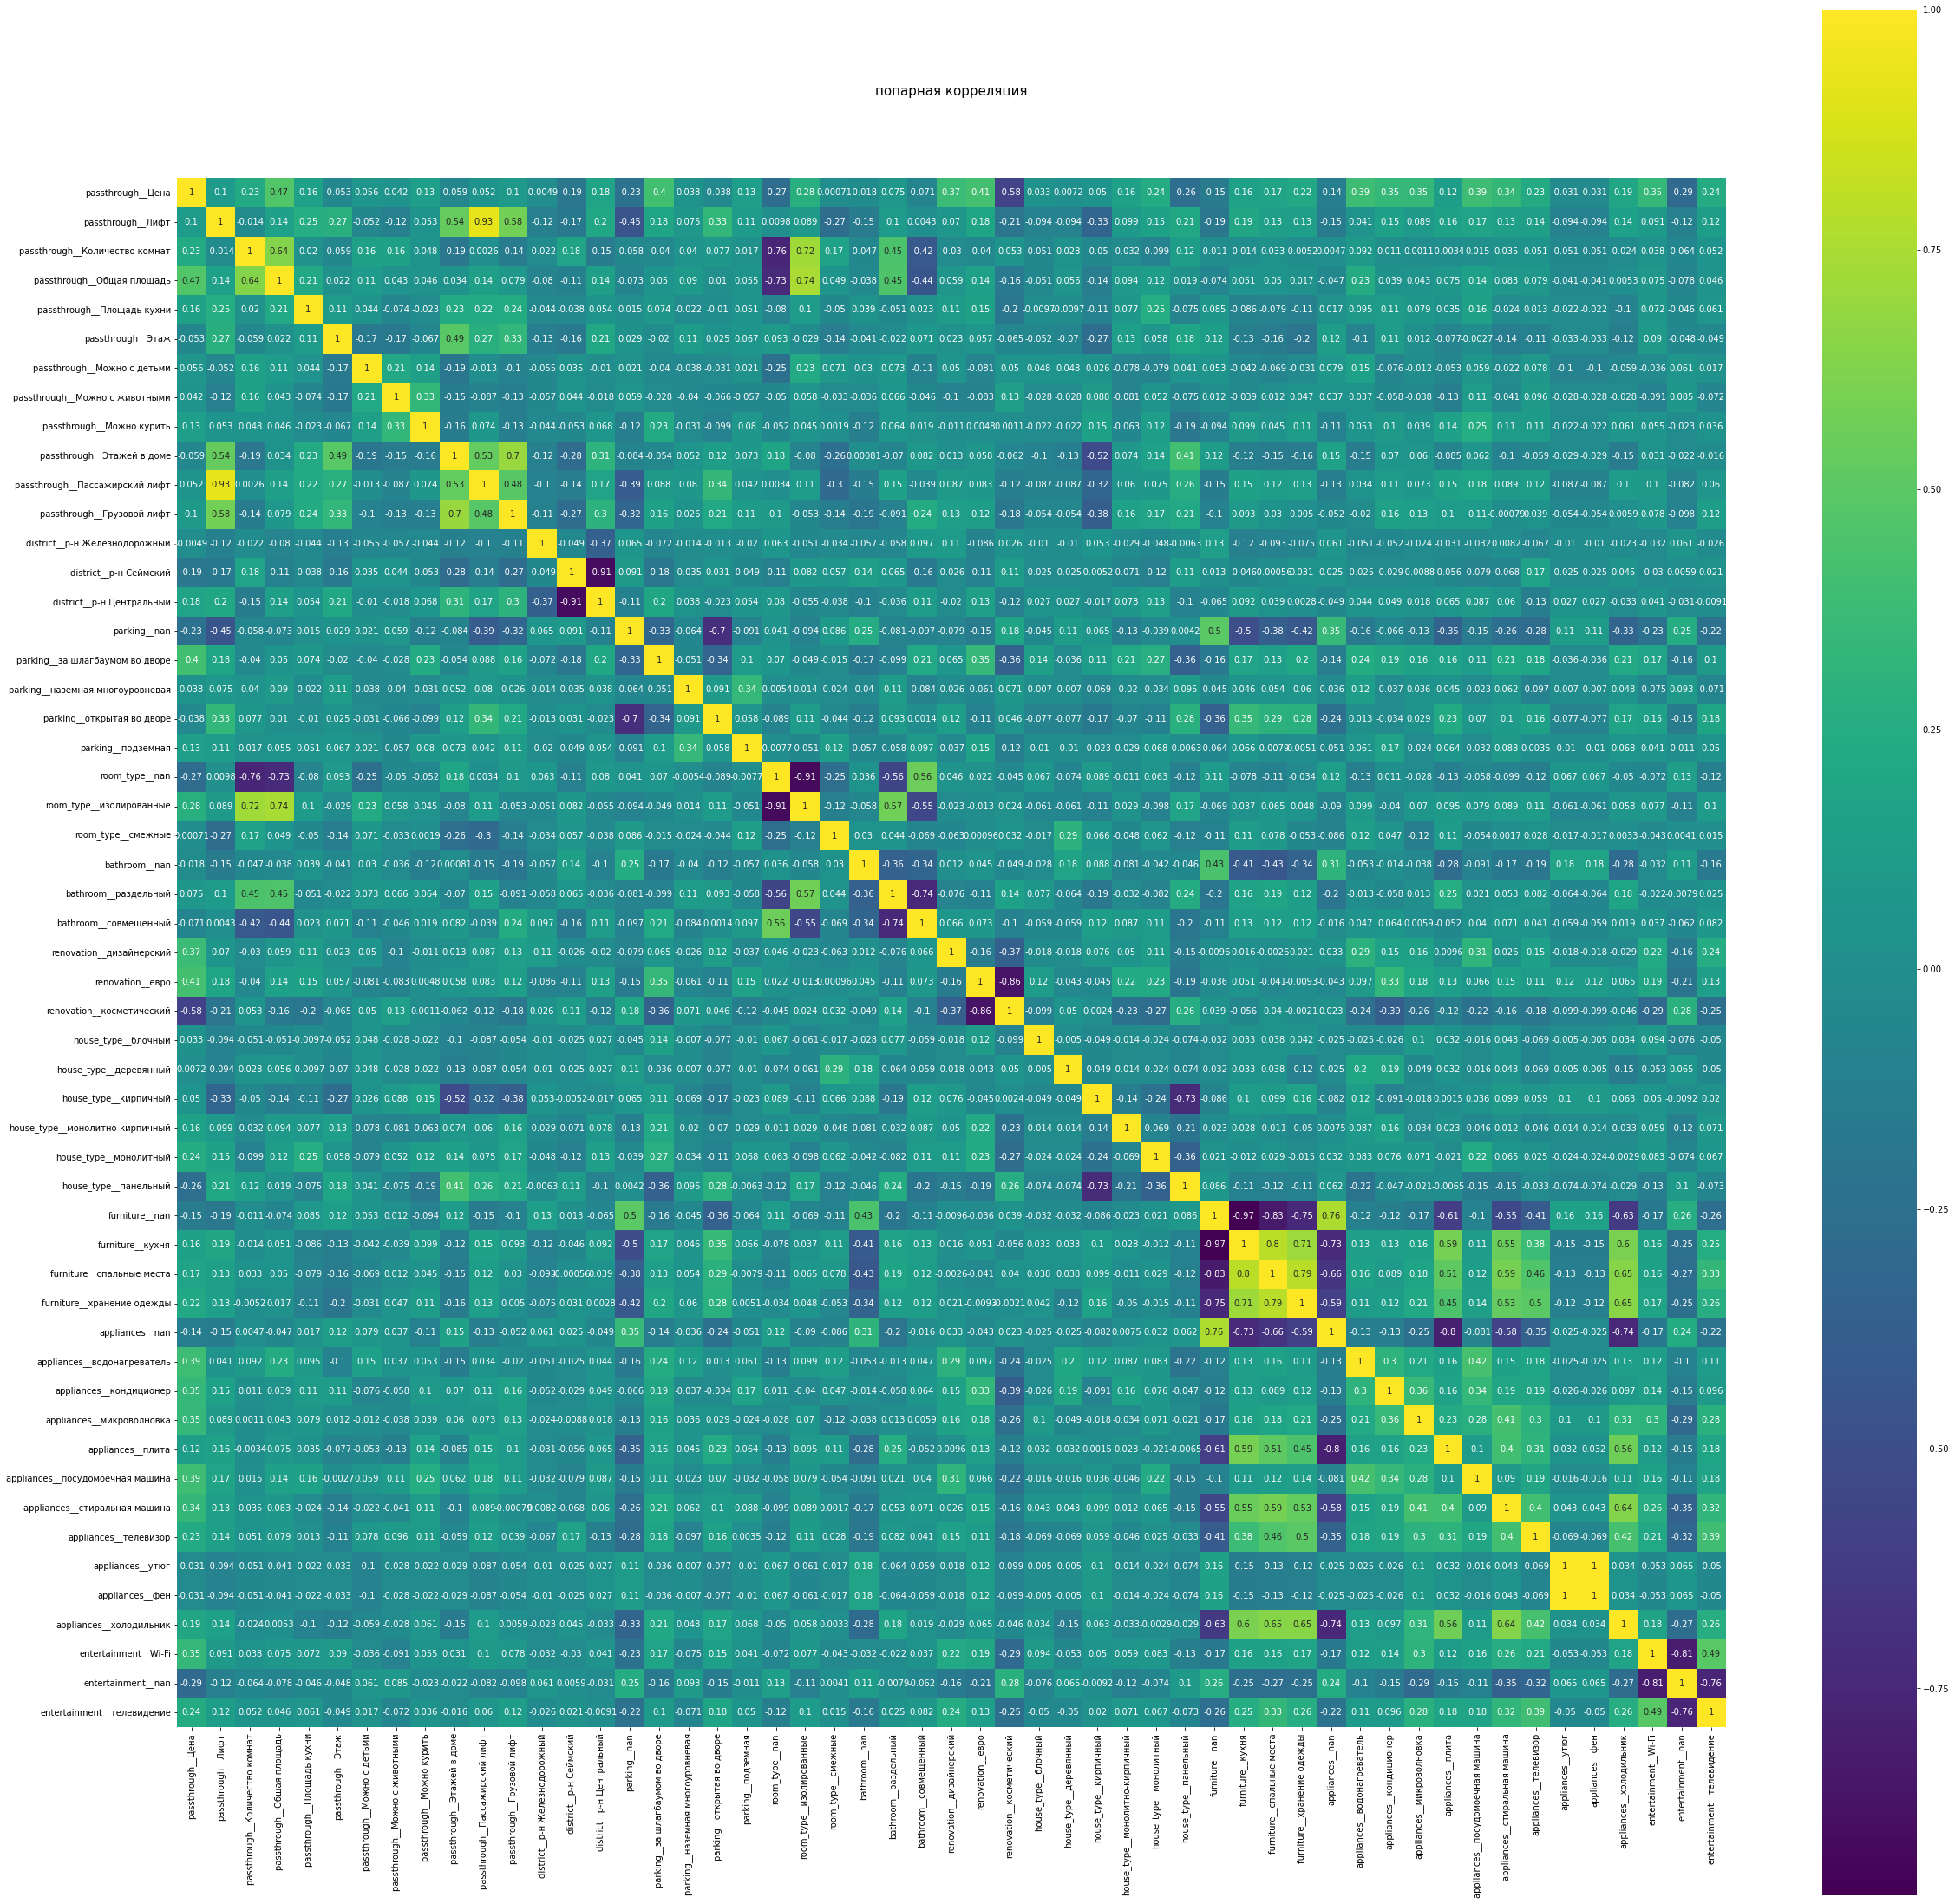

In [10]:
colormap = plt.cm.viridis
plt.figure(figsize=(40, 40))
plt.title('попарная корреляция', y=1.05, size=15)
sns.heatmap(corr_matrix, square=True, annot=True, cmap=colormap)
plt.show()

In [12]:
final_features = ['passthrough__Цена', 'passthrough__Общая площадь', 'passthrough__Лифт',
                  'district__р-н Сеймский', 'district__р-н Центральный', 
                  'parking__за шлагбаумом во дворе', 'parking__nan',
                  'room_type__изолированные', 
                  'renovation__дизайнерский', 'renovation__евро', 'renovation__косметический',
                  'house_type__панельный',
                  'furniture__кухня', 'furniture__спальные места', 'furniture__хранение одежды',
                  'appliances__водонагреватель', 'appliances__кондиционер', 'appliances__микроволновка', 
                  'appliances__посудомоечная машина', 'appliances__стиральная машина',
                  'appliances__телевизор']
model_df = transformed_df[final_features]

In [13]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(model_df)
scaled = scaler.transform(model_df)
scaled_df = pd.DataFrame(scaled, columns=model_df.columns)
scaled_df.head()

,passthrough__Цена,passthrough__Общая площадь,passthrough__Лифт,district__р-н Сеймский,district__р-н Центральный,parking__за шлагбаумом во дворе,parking__nan,room_type__изолированные,renovation__дизайнерский,renovation__евро,...,house_type__панельный,furniture__кухня,furniture__спальные места,furniture__хранение одежды,appliances__водонагреватель,appliances__кондиционер,appliances__микроволновка,appliances__посудомоечная машина,appliances__стиральная машина,appliances__телевизор
0,0.88,0.927536,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0
1,0.28,0.608696,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
2,0.32,0.855072,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.40,1.000000,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.12,0.362319,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
X = scaled_df.drop(['passthrough__Цена'], axis=1)
y = scaled_df['passthrough__Цена']

In [15]:
from sklearn.model_selection import train_test_split
for state in range(100):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.1, random_state=2)

In [16]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.ensemble import BaggingClassifier

In [17]:
models = dict()
models["sgdr"] = SGDRegressor()
models["lr"] = LinearRegression()
models["ridge"] = Ridge()
models["svr_linear"] = SVR(kernel='linear')
models["svr_rbf"] = SVR(kernel='rbf')
models["lasso"] = Lasso()
models["elastic"] = ElasticNet()

In [18]:
def check_results(X, y, cv=5):
    models_results = []
    for model in models:
        scores = cross_val_score(models[model], X, y, cv=cv)
        result = {
            'model': model,
            'mean': round(scores.mean(), 3),
            'max': round(scores.max(), 3)
        }
        models_results.append(result)
    return sorted(models_results, key=lambda x: x['mean'], reverse=True)

In [19]:
results = check_results(X, y)
print(json.dumps(results, indent=4))

[
    {
        "model": "ridge",
        "mean": 0.574,
        "max": 0.76
    },
    {
        "model": "lr",
        "mean": 0.571,
        "max": 0.749
    },
    {
        "model": "svr_linear",
        "mean": 0.568,
        "max": 0.699
    },
    {
        "model": "sgdr",
        "mean": 0.46,
        "max": 0.588
    },
    {
        "model": "svr_rbf",
        "mean": 0.46,
        "max": 0.61
    },
    {
        "model": "lasso",
        "mean": -0.101,
        "max": -0.001
    },
    {
        "model": "elastic",
        "mean": -0.101,
        "max": -0.001
    }
]
